<a href="https://colab.research.google.com/github/lapshinaaa/homework_DeepLearning/blob/main/Lapshina_recommendations_hw_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def apk(relevant: List[int], predicted: List[int], k: int) -> float:
    # function for computing average precision
    if len(predicted) > k:
        predicted = predicted[:k] # if length of predictions > k

    score = 0.0
    count_relev = 0.0

    for i, p in enumerate(predicted):
        if p in relevant and p not in predicted[:i]: # check if the item has not been encountered before
            count_relev += 1.0 # if the item is relevant, increment count and score
            score += count_relev / (i + 1.0) # calculate p@k

    return score / min(len(relevant), k)

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20) -> float:
    # function for computing mean AP
    return sum(apk(r, p, k) for r, p in zip(relevant, predicted)) / len(relevant)

In [5]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [6]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [7]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [8]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [9]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [10]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [11]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [12]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [13]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [14]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        for user in range(self.n_users):
          user_recommendation = self.recommend(user) # get a recommendation
          test_preds.append(user_recommendation) # append this recommendation

        # get rid of already listened tracks
        test_preds = self.remove_train_items(test_preds, k)

        test_users = np.unique(self.ratings['userId']) # get unique users

        return test_preds[test_users] # return recommendations for the unique test users

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

**For better understanding I used:** https://www.geeksforgeeks.org/how-to-calculate-jaccard-similarity-in-python/?ysclid=lww5c0fyq684890838  and https://medium.com/@TheDataScience-ProF/exploring-jaccard-similarity-a-powerful-tool-for-similarity-analysis-in-python-6767ed21377a

In [15]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    # create intersection mask Iu Iv for further calculations
    intersection = (ratings > 0) & (user_vector > 0)

    # calculate numerator (sum of dot product)
    numerator = np.sum(ratings * user_vector * intersection, axis=1)

    # calculate denominator according to the formula above
    first_mult = np.sqrt(np.sum((ratings)** 2, axis=1))
    second_mult = np.sqrt(np.sum((user_vector)**2))
    denominator = first_mult * second_mult

    denominator = np.where(denominator == 0, 1e-10, denominator) # avoiding division by zero
    pearson_correlation = numerator / denominator # final calculation of the metric

    return pearson_correlation


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # calculate intersection
    intersection = np.sum((ratings > 0) & (user_vector > 0), axis=1)

    # calculate union
    union = np.sum((ratings > 0) | (user_vector > 0), axis=1)
    union = np.where(union == 0, 1e-10, union)  # avoiding division by zero in denominator

    jaccard_similarity = intersection/union

    return jaccard_similarity

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [23]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        similarity = self.similarity_func(self.R, user_vector) # calculate similarity metrics
        return similarity

    def recommend(self, uid: int):
        user_vector = self.R[uid] # first, we're taking the user vector
        similarities = self.similarity(user_vector) # calculate similarity between our target user and others

        # according to the formula above, find neighbors of the target user
        set_neighbors = [i for i in range(self.n_users) if i != uid and similarities[i] > self.alpha]

        ratings_predictions = np.zeros(self.n_items) # to store predictions
        # iterate over items to get ratings predictions
        for track in range(self.n_items):
          # calculate numerator
          numerator = np.sum([similarities[neighbor] * self.R[neighbor, track] for neighbor in set_neighbors])

          # calculate denominator
          denominator = np.sum([abs(similarities[neighbor]) for neighbor in set_neighbors])

          # add calculated predictions
          if denominator != 0:
            ratings_predictions[track] = numerator / denominator

        # sorting in descending order
        recommendations = np.argsort(ratings_predictions)[::-1]
        return recommendations

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [24]:
k_list = [5, 10, 20]

# jaccard and pearson models
pearson_model = User2User(train_ratings, pearson)
jaccard_model = User2User(train_ratings, jaccard)

# calculating MAP@k
pearson_mapk = []
jaccard_mapk = []
random_mapk = []

for k in k_list:
  # getting recommendations according to the metrics
  pearson_recommendations = pearson_model.get_test_recommendations(k)
  jaccard_recommendations = jaccard_model.get_test_recommendations(k)
  random_recommendations = [np.random.choice(np.arange(pearson_model.n_items), k, replace=False) for _ in range(pearson_model.n_users)]

  # caclulate MAP@k
  pearson_mapk.append(mapk(test_relevant, pearson_recommendations, k))
  jaccard_mapk.append(mapk(test_relevant, jaccard_recommendations, k))
  random_mapk.append(mapk(test_relevant, random_recommendations, k))

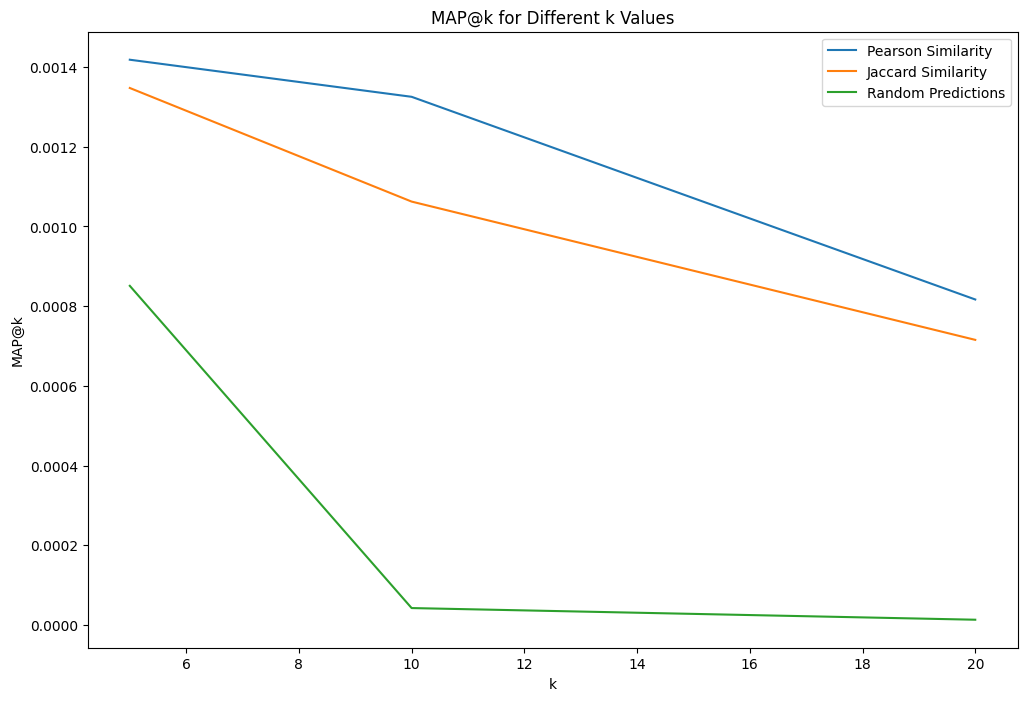

In [25]:
# plotting results
plt.figure(figsize=(12, 8))
plt.plot(k_list, pearson_mapk, label='Pearson Similarity')
plt.plot(k_list, jaccard_mapk, label='Jaccard Similarity')
plt.plot(k_list, random_mapk, label='Random Predictions')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for Different k Values')
plt.legend()
plt.show()

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
user_id = np.random.randint(0, model.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
300,All Star,['Smash Mouth']
831,Tokyo Drift (Fast & Furious),['Teriyaki Boyz']
7272,Around the World (La La La La La),['A Touch Of Class']
8119,Still D.R.E.,['Dr. Dre']
9366,The X-Files,['The X Project']
10707,End Credits,['Hans Zimmer']
16623,Dum Dee Dum,['Keys N Krates']
16911,Mi Mi Mi,['Selene RMX']
18237,Turn Down for What,"['DJ Snake', 'Lil Jon']"
19333,Turn Down for What,"['DJ Snake', 'Lil Jon', 'Juicy J', '2 Chainz',..."


In [ ]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

  0%|          | 0/241 [00:00<?, ?it/s]

Predicted tracks:


,name,artists
2814,Numb,['Linkin Park']
24500,Way Down We Go,['KALEO']
1073,Smells Like Teen Spirit,['Nirvana']
805,Zombie,['The Cranberries']
1019,It's My Life,['Bon Jovi']
11493,The Show Must Go On,['Queen']
7533,Highway to Hell,['AC/DC']
49577,Кукла колдуна,['Король и Шут']
18459,Take Me To Church,['Hozier']
8263,Shape Of My Heart,['Sting']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
65569,Little Do You Know Beat Cry,['Yagih Mael']
65897,Life Goes On,['Oliver Tree']
65904,Gdzie jest biały węgorz ? (Zejście),['Cypis']
65918,Him & Her,['Pacino']
65948,I WANT YOU BACK,['Dazel Ukuto']
65967,Levan Polka,"['Dance', 'Tendência', 'Baila']"
66260,Levan Polkka,['Dj Mix Urbano']
66261,Kulikitaka Challenge,['Dj Mix Urbano']
66299,In Da Getto,"['J. Balvin', 'Skrillex']"
66314,Entrenamiento en el Gym,['Gimnasio de motivación']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Ответ

\\
**ALS:**

Ответ



**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                pass

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                pass

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
5517,Варвара,['Би-2'],0.649796
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.646846
2058,Последний герой,['КИНО'],0.640997
5872,Я свободен,['Кипелов'],0.606749
2060,Хочу перемен,['КИНО'],0.603231
5515,Романс,['Сплин'],0.590318
24284,Как на войне,['Агата Кристи'],0.586219
4463,Holiday,['Green Day'],0.576644
2179,Восьмиклассница,['КИНО'],0.570639
